In [34]:
using Turing
using Distributions
using DataFrames
using Random
using Plots
using StatsPlots

# Set seed for reproducibility
Random.seed!(123)

# Generate sample data
n_samples = 1000

DaysSinceLastActivity = rand(Exponential(10), n_samples) # Average 10 days since last activity
HasActivePromotionalOffer = rand([0, 1], n_samples)
AverageSessionDuration = rand(Gamma(2, 15), n_samples) # Average session duration around 30 minutes

p_churn = 0.3 # True churn probability

labels = zeros(Int, n_samples)


println("DaysSinceLastActivity")
display(first(DaysSinceLastActivity, 10))
println("HasActivePromotionalOffer")
display(first(HasActivePromotionalOffer, 5))
println("AverageSessionDuration")
display(first(AverageSessionDuration, 10))
println("labels")
display(first(labels, 5))

DaysSinceLastActivity


10-element Vector{Float64}:
  9.96583929602089
 13.776640797287795
 34.00074551909927
  4.809598208729327
  4.566533832629473
  2.2991668464103148
  5.774810411507476
  2.3641805109467526
  0.7044544222448661
  1.526718763342565

HasActivePromotionalOffer


5-element Vector{Int64}:
 1
 1
 1
 1
 0

AverageSessionDuration


10-element Vector{Float64}:
   8.873693141008838
  21.335584701144803
  21.14678528496186
 129.83873975726576
  38.405308256232864
  81.81822183319751
  13.111048194117178
  33.97379380944895
  28.16675700196604
  24.791881557895838

labels


5-element Vector{Int64}:
 0
 0
 0
 0
 0

In [35]:
for i in 1:n_samples
    prob_churn = p_churn * pdf(Exponential(8), DaysSinceLastActivity[i]) * pdf(Bernoulli(0.2), HasActivePromotionalOffer[i]) * pdf(Gamma(1.5, 20), AverageSessionDuration[i]) #Churn distribution
    prob_no_churn = (1-p_churn) * pdf(Exponential(12), DaysSinceLastActivity[i]) * pdf(Bernoulli(0.8), HasActivePromotionalOffer[i]) * pdf(Gamma(2.5, 10), AverageSessionDuration[i]) #No churn distribution

    prob_churn_norm = prob_churn / (prob_churn + prob_no_churn)
    labels[i] = rand() < prob_churn_norm ? 1 : 0 # 1: Churn, 0: No Churn
end

df = DataFrame(DaysSinceLastActivity = DaysSinceLastActivity, HasActivePromotionalOffer = HasActivePromotionalOffer, AverageSessionDuration = AverageSessionDuration, Churn = labels)

println("labels after")
display(first(labels, 5))
println("df")
display(first(df, 10))

labels after


5-element Vector{Int64}:
 1
 0
 0
 1
 1

df


Row,DaysSinceLastActivity,HasActivePromotionalOffer,AverageSessionDuration,Churn
,Float64,Int64,Float64,Int64
1,9.96584,1,8.87369,1
2,13.7766,1,21.3356,0
3,34.0007,1,21.1468,0
4,4.8096,1,129.839,1
5,4.56653,0,38.4053,1
6,2.29917,0,81.8182,1
7,5.77481,0,13.111,0
8,2.36418,1,33.9738,0
9,0.704454,1,28.1668,0


┌ Info: Found initial step size
└   ϵ = 0.00625
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:02


Chains MCMC chain (1000×21×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 3.42 seconds
Compute duration  = 3.42 seconds
parameters        = p_churn, λ_churn, λ_no_churn, p_promo_churn, p_promo_no_churn, k_session_churn, θ_session_churn, k_session_no_churn, θ_session_no_churn
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
          parameters      mean       std      mcse    ess_bulk   ess_tail      ⋯
              Symbol   Float64   Float64   Float64     Float64    Float64   Fl ⋯

             p_churn    0.4881    0.2855    0.0069   1684.2008   605.2718    1 ⋯
             λ_churn    8.0251    0.4654    0.0131   1278.2759   749.5205    1 ⋯
          λ_no_churn   10.5125    0.4059    0.0117   1203.8063   696.4496    0 ⋯
       p_promo_churn

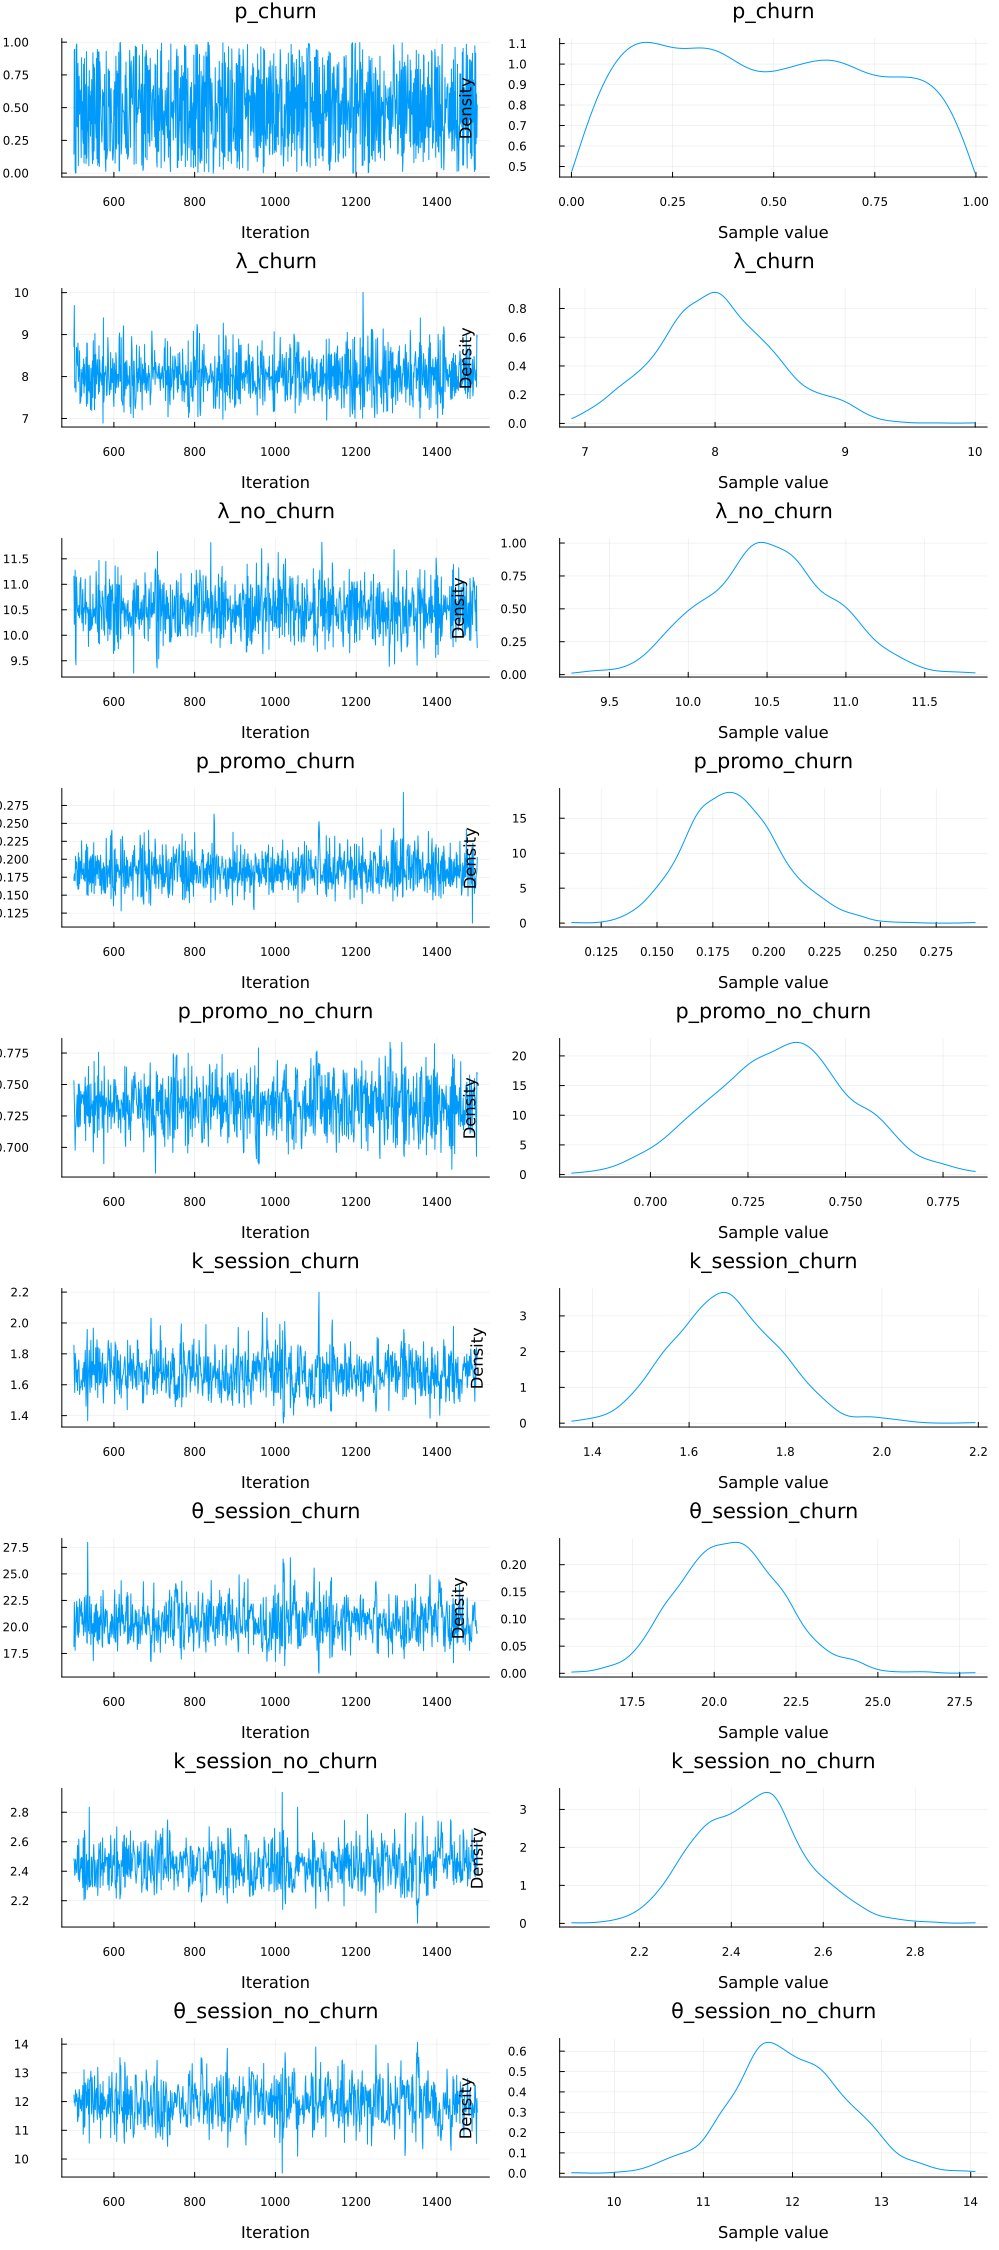

Probability of Churning: 0.6322806828427239


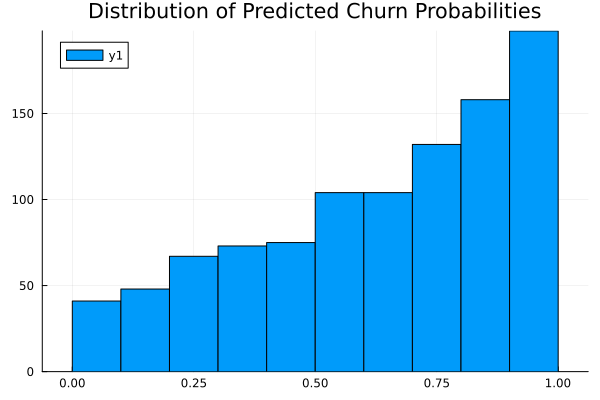

In [36]:
# Turing model
@model function churn_model(DaysSinceLastActivity, HasActivePromotionalOffer, AverageSessionDuration, Churn)
    # Priors for class probabilities
    p_churn ~ Beta(1, 1) # Prior for churn probability
    p_no_churn = 1 - p_churn

    # Priors for distribution parameters (one set per class)
    λ_churn ~ truncated(Normal(8, 2), lower = 0) # Prior for churn distribution
    λ_no_churn ~ truncated(Normal(12, 2), lower = 0) # Prior for no churn distribution

    p_promo_churn ~ Beta(0.2, 1) # Prior for churn distribution
    p_promo_no_churn ~ Beta(0.8, 1) # Prior for no churn distribution

    k_session_churn ~ truncated(Normal(1.5, 1), lower = 0)
    θ_session_churn ~ truncated(Normal(20, 5), lower = 0)
    k_session_no_churn ~ truncated(Normal(2.5, 1), lower = 0)
    θ_session_no_churn ~ truncated(Normal(10, 5), lower = 0)

    # Likelihood
    for i in 1:length(Churn)
        if Churn[i] == 1 # Churn
            DaysSinceLastActivity[i] ~ Exponential(λ_churn)
            HasActivePromotionalOffer[i] ~ Bernoulli(p_promo_churn)
            AverageSessionDuration[i] ~ Gamma(k_session_churn, θ_session_churn)
        else # No Churn
            DaysSinceLastActivity[i] ~ Exponential(λ_no_churn)
            HasActivePromotionalOffer[i] ~ Bernoulli(p_promo_no_churn)
            AverageSessionDuration[i] ~ Gamma(k_session_no_churn, θ_session_no_churn)
        end
    end

    return p_churn, λ_churn, λ_no_churn, p_promo_churn, p_promo_no_churn, k_session_churn, θ_session_churn, k_session_no_churn, θ_session_no_churn
end

# Create and sample the model
model = churn_model(df.DaysSinceLastActivity, df.HasActivePromotionalOffer, df.AverageSessionDuration, df.Churn)
chain = sample(model, NUTS(0.65), 1000)

display(chain)
display(plot(chain))
# savefig("chains.png")

# Prediction
function predict_churn_probability(
    chain,
    new_DaysSinceLastActivity,
    new_HasActivePromotionalOffer,
    new_AverageSessionDuration
)
    # ... (same prediction logic as before, just with new variable names)
    n_samples = length(chain)
    prob_churn = zeros(n_samples)
    for i in 1:n_samples
        λ_churn_i = chain[:λ_churn][i]
        p_promo_churn_i = chain[:p_promo_churn][i]
        k_session_churn_i = chain[:k_session_churn][i]
        θ_session_churn_i = chain[:θ_session_churn][i]
        λ_no_churn_i = chain[:λ_no_churn][i]
        p_promo_no_churn_i = chain[:p_promo_no_churn][i]
        k_session_no_churn_i = chain[:k_session_no_churn][i]
        θ_session_no_churn_i = chain[:θ_session_no_churn][i]
        p_churn_i = chain[:p_churn][i]
        p_no_churn_i = 1 - p_churn_i

        prob_churn_unnorm = p_churn_i * pdf(Exponential(λ_churn_i), new_DaysSinceLastActivity) * pdf(Bernoulli(p_promo_churn_i), new_HasActivePromotionalOffer) * pdf(Gamma(k_session_churn_i, θ_session_churn_i), new_AverageSessionDuration)
        prob_no_churn_unnorm = p_no_churn_i * pdf(Exponential(λ_no_churn_i), new_DaysSinceLastActivity) * pdf(Bernoulli(p_promo_no_churn_i), new_HasActivePromotionalOffer) * pdf(Gamma(k_session_no_churn_i, θ_session_no_churn_i), new_AverageSessionDuration)
        prob_churn[i] = prob_churn_unnorm / (prob_churn_unnorm + prob_no_churn_unnorm)
    end
    return prob_churn
end

new_DaysSinceLastActivity = 15
new_HasActivePromotionalOffer = 0
new_AverageSessionDuration = 10
churn_probabilities = predict_churn_probability(chain, new_DaysSinceLastActivity, new_HasActivePromotionalOffer, new_AverageSessionDuration)
println("Probability of Churning: ", mean(churn_probabilities))

display(histogram(churn_probabilities, title="Distribution of Predicted Churn Probabilities"))
# savefig("churn_probs_hist.png")

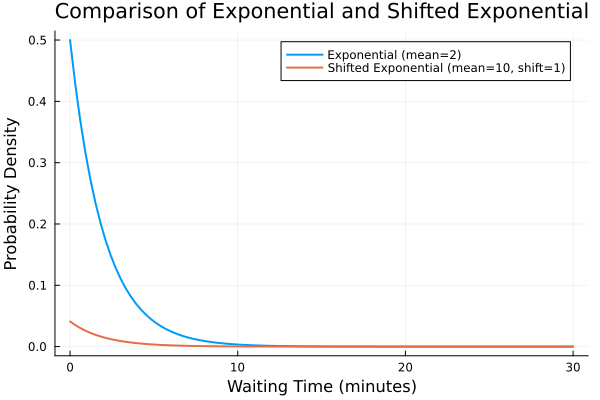

In [19]:
using Distributions
using Plots

# x values for plotting
x_values = range(0, 30, length = 100)

# Exponential distribution
exp_dist = Exponential(2)
y_exp = pdf.(exp_dist, x_values)
plot(x_values, y_exp, label="Exponential (mean=2)", linewidth=2)

# Shifted exponential distribution (minimum wait time of 1 minute)
offset = 5
x_shifted = x_values .+ offset # Shift the x-values
y_shifted = pdf.(exp_dist, x_shifted) # Evaluate the original PDF at shifted x-values
plot!(x_values, y_shifted, label="Shifted Exponential (mean=10, shift=1)", linewidth=2)

xlabel!("Waiting Time (minutes)")
ylabel!("Probability Density")
title!("Comparison of Exponential and Shifted Exponential")
# savefig("shifted_exponential.png")